<a href="https://colab.research.google.com/github/AniaSzymczak/Dane_Bioinformatyka_lab5/blob/main/lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install git
!git clone https://github.com/AniaSzymczak/Dane_Bioinformatyka_lab5.git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Cloning into 'Dane_Bioinformatyka_lab5'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 4), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 368.15 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install numpy

In [ ]:
import os
os.chdir("/content/Dane_Bioinformatyka_lab5")

In [ ]:
from Bio.PDB import MMCIFParser, PDBIO
from Bio.PDB.Superimposer import Superimposer
from numpy import array
import numpy as np

def calculate_rmsd(coord1, coord2):
  diff = coord1 - coord2
  result = np.sqrt(np.sum(np.square(diff) / len(coord1)))
  return result

parser = MMCIFParser(QUIET=True)
structure_ref = parser.get_structure("model_ref.cif","model_ref.cif")

def get_ca_atoms(structure):
  ca_atoms = []
  ids = []
  for model in structure:
    for chain in model:
      for residue in chain:
        if residue.has_id("CA") and residue.has_id("N") and residue.has_id("C"):
          ca_atoms.append(residue["CA"])
          ca_atoms.append(residue["N"])
          ca_atoms.append(residue["C"])
          ids.append(residue.id)
  return np.array(ca_atoms), ids


atoms_ref, ids_ref = get_ca_atoms(structure_ref)

super_imposer = Superimposer()
for i in range(5):
  common_atoms_ref = []
  common_atoms = []
  structure = parser.get_structure(f"model_{i}.cif",f"model_{i}.cif")
  atoms, ids = get_ca_atoms(structure)
  for ref_atom, ref_id in zip(atoms_ref, ids_ref):
    if ref_id in ids:
      idx = ids.index(ref_id)
      common_atoms_ref.append(ref_atom)
      common_atoms.append(atoms[idx])

  super_imposer.set_atoms(common_atoms_ref, common_atoms)
  super_imposer.apply(structure.get_atoms())
  rmsd = calculate_rmsd(array(common_atoms_ref), array(common_atoms))
  print(f"RMSD dla modelu {i}: {round(rmsd,4)}")
  io = PDBIO()
  io.set_structure(structure)
  with open(f"output_{i}.pdb", "w") as file:
    io.save(file)
    print(f"Zapisano zmodyfikowany model {i} do output_{i}.pdb")

RMSD dla modelu 0: 0.408
Zapisano zmodyfikowany model 0 do output_0.pdb
RMSD dla modelu 1: 0.4443
Zapisano zmodyfikowany model 1 do output_1.pdb
RMSD dla modelu 2: 0.4422
Zapisano zmodyfikowany model 2 do output_2.pdb
RMSD dla modelu 3: 0.4154
Zapisano zmodyfikowany model 3 do output_3.pdb
RMSD dla modelu 4: 0.4026
Zapisano zmodyfikowany model 4 do output_4.pdb


Najlepsze RMSD: output_4.pdb
Najgorsze RMSD: output_1.pdb
<


Zadanie 4

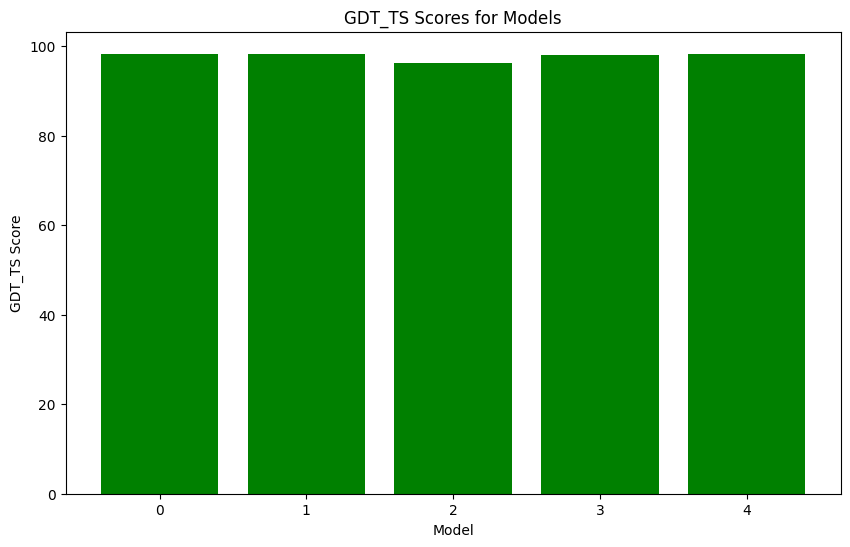

In [ ]:
from Bio.PDB import MMCIFParser, PDBIO
from Bio.PDB.Superimposer import Superimposer
import matplotlib.pyplot as plt
import numpy as np

def calculate_gdt_ts(atoms_ref, atoms, threshold=1.0):
    ref_coords = np.array([atom.coord for atom in atoms_ref])
    pred_coords = np.array([atom.coord for atom in atoms])
    distances = np.linalg.norm(ref_coords - pred_coords, axis=1)
    gdt_scores = []
    gdt_scores.append (np.sum(distances <= threshold) / len(atoms_ref))
    gdt = gdt_scores[0] * 100
    return gdt

parser = MMCIFParser(QUIET=True)
structure_ref = parser.get_structure("reference", "model_ref.cif")

def get_ca_atoms(structure):
    ca_atoms = []
    ids = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.has_id("CA"):
                    ca_atoms.append(residue["CA"])
                    ids.append(residue.id)
    return ca_atoms, ids

atoms_ref, ids_ref = get_ca_atoms(structure_ref)
all_results = []
super_imposer = Superimposer()

for i in range(5):
    common_atoms_ref = []
    common_atoms = []
    structure = parser.get_structure(f"model_{i}", f"model_{i}.cif")
    atoms, ids = get_ca_atoms(structure)

    for ref_atom, ref_id in zip(atoms_ref, ids_ref):
        if ref_id in ids:
            idx = ids.index(ref_id)
            common_atoms_ref.append(ref_atom)
            common_atoms.append(atoms[idx])

    super_imposer.set_atoms(common_atoms_ref, common_atoms)
    # super_imposer.apply([atom for atom in structure.get_atoms()])
    super_imposer.apply(structure.get_atoms())


    results = calculate_gdt_ts(common_atoms_ref, common_atoms)
    all_results.append(results)

def plot_gdt_ts_scores(all_results):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(all_results)), all_results, color="green")
    plt.xlabel("Model")
    plt.ylabel("GDT_TS Score")
    plt.title("GDT_TS Scores for Models")
    plt.show()

plot_gdt_ts_scores(all_results)

Zadanie 5

In [ ]:
from Bio.PDB import PDBParser
import math


def calculate_distance(atom1, atom2):
    coord1 = atom1.get_coord()
    coord2 = atom2.get_coord()
    return math.sqrt(sum((coord1 - coord2) ** 2))

def is_backbone(atom_name):
    return atom_name in { 'N','CA', 'C','H'}

def get_vdw_radius(atom):
    vdw_radii = {
        'H': 1.20, 'C': 1.70, 'N': 1.55, 'O': 1.52, 'S': 1.80, 'P': 1.80
    }
    element = atom.element
    return vdw_radii.get(element, 1)

def clash_score(structure):
    atoms = []
    for model in structure:
        for chain in model:
            residues = list(chain)
            for i, residue in enumerate(residues):
                if residue.id[0] != ' ':
                    continue
                for atom in residue:
                    if not is_backbone(atom.get_name()):
                        atoms.append((residue, atom))
    score = 0
    num_atoms = len(atoms)
    for i in range(num_atoms):
        res1, atom1 = atoms[i]
        for j in range(i + 1, num_atoms):
            res2, atom2 = atoms[j]
            if abs(res1.get_id()[1] - res2.get_id()[1]) <= 1:
                continue
            if (atom1.get_name() == 'N' and atom2.get_name() == 'CA') or \
                    (atom1.get_name() == 'CA' and atom2.get_name() == 'C'):
                continue
            distance = calculate_distance(atom1, atom2)
            r1 = get_vdw_radius(atom1)
            r2 = get_vdw_radius(atom2)
            if distance <= (r1 + r2 - 0.4):
                score += 1

    clash_score_value = (score / num_atoms) * 1000
    return clash_score_value

structure_name = "4ywo.pdb"
parser = PDBParser(QUIET=True)
structure = parser.get_structure(structure_name, structure_name)
score = clash_score(structure)
print(f"Clash Score: {score:.2f}")

Clash Score: 1.97
